Based upon [Gökçen Eraslan's PyCon talk](https://github.com/gokceneraslan/dnaconvnet-notebook).

## Discovering DNA motifs using convolutional neural networks

The goal is to train a convolutional neural network to recognize a given DNA sequence motif given a  synthetic set of training examples (sequences) that have been labeled according to whether they contain the motif or not. In other words, the convolution filter of the network should evolve during training towards the known "frequency matrix" of the motif. 

## EWSR1 motif 

We fetch the following motif from [JASPAR](http://jaspar.genereg.net/cgi-bin/jaspar_db.pl?ID=MA0149.1&rm=present&collection=CORE):
![title](http://jaspar.genereg.net/static/logos/MA0149.1.BIG.png)


This motif is a visualization of the "frequency matrix":

In [5]:
import numpy as np
motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
                  [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
                  [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
                  [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])

Each row in this matrix corresponds to a possible nucleotide and the columns correspond to  position in a binding site. The matrix elements indicate the frequency with with which the corresponding nucleotide was observed at the corresponding position in the binding site. 

## Training examples 

We wish to create a set of "positive" training examples in which the motif is embedded. We can do this by extending the frequency matrix upstream and downstream of the binding site using equal frequencies for each of the possible nucleotides: 

In [71]:
sequence_length = 40
motif_plus_background = np.hstack([np.ones((4,(sequence_length-motif.shape[1])//2)), 
                                   motif,
                                   np.ones((4,(sequence_length-motif.shape[1])//2))])

number_training_examples = 1000
training_examples_positive = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_training_examples//2, 
                           p=motif_plus_background[:,position]/float(np.sum(motif_plus_background[:,position]))) 
          for position in range(sequence_length)]).transpose()

sequences_positive = []
for training_example_positive in training_examples_positive: 
    sequences_positive.append(''.join(training_example_positive))
    
labels_positive = np.ones(shape=len(sequences_positive), dtype=int)

Now let's produce the negative training examples by sampling nucleotides with equal frequency, regardless of their position in the sequence: 

In [72]:
training_examples_negative = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_training_examples//2, 
                           p=np.array([1,1,1,1])/4.0) 
          for position in range(sequence_length)]).transpose()

sequences_negative = []
for training_example_negative in training_examples_negative: 
    sequences_negative.append(''.join(training_example_negative))

labels_negative = np.zeros(shape=len(sequences_negative), dtype=int)

Wrap the examples up in a dataframe to visualize the positive examples...

In [74]:
df_training = pd.DataFrame(OrderedDict([('sequence', np.concatenate((sequences_positive, sequences_negative))),
                                        ('observed_label', np.concatenate((labels_positive, labels_negative)))]))
df_training[:5]

,sequence,observed_label
0,GGACGAGTCCTGGAAGGAAGGAAGGAAGGCCCTTGCCGCG,1
1,GTTGCTAGACTGGAAGGAAGGCAGGAAGGTCTCCACTACC,1
2,ACCCTAGGTATGGAAGGAAGGAAGGAAGGGAAGAAATCTA,1
3,CTATGGTAGTGGGAAGGAAGGAAGGATGGTTAATTTAATT,1
4,GAGTCGGTGGAGGAAGGAAGGAAGGAAGGGAAGAAGTTAT,1


... and the negative examples: 

In [75]:
df_training[500:505]

,sequence,observed_label
500,AATCGCCACGTTTCCTTGGTTGAAACTCCTAAAGCTTAAC,0
501,ATACGTAAGTCCCTTGTGGTGTTAAGTCATACGGTCGACG,0
502,CCTGCCTGACATGAAAACCCCATTTTCCCCTTACTATCGT,0
503,TATTTGTGTGCACCATTGGATCCGGGTCCCAGTTTTATAC,0
504,GCAGCGGGTGATGCGTACGAGAAAAAAACGGCCCGATGAT,0


## Learning the motif using a convolution network 

Since the sequences are categorical data, we must encode them as numbers before passing them into a function that maps them to class labels. We use "one-hot encoding", creating a tensor with dimensions `(number_examples, sequence_length, number_channels)` : 

In [116]:
from load_preprocess_data import _one_hot_encode_conv1d

encoded_sequences = []
for sequence in df_training['sequence']:
    encoded_sequences.append(_one_hot_encode_conv1d(sequence))
encoded_sequences = np.array(encoded_sequences)
print('encoded_sequences.shape: ', encoded_sequences.shape)

observed_labels = np.array(df_training['observed_label']).reshape(-1, 1)
print('observed_labels.shape', observed_labels.shape)

encoded_sequences.shape:  (1000, 40, 4)
observed_labels.shape (1000, 1)


Next, we set up and train a convolution neural network to map sequence to labels: 

In [117]:
# https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
import keras.backend as K
K.clear_session()

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv1D(filters=1, 
                 kernel_size=motif.shape[1], 
                 input_shape=(sequence_length, 4), 
                 activation='relu'))

# INVERTED DROPOUT
# "Dropout" gets applied to the output of preceding layer (at training time only):
# https://keras.io/layers/core/#dropout
# weights are scaled by inverse of dropout rate (at training time only):
# see: line 2277 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
# also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
# also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
model.add(Dropout(rate=0.7))

model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              loss='binary_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath="model.best.hdf5", 
                             save_weights_only=False,
                             monitor='val_acc', 
                             verbose=1,
                             save_best_only=True,
                             period=2)

from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./logs', 
                          histogram_freq=1, 
                          write_graph=False, 
                          write_grads=True, 
                          write_images=True)

history = model.fit(x=encoded_sequences, 
                    y=observed_labels, 
                    validation_split=0.2, 
                    epochs=10,
                    callbacks=[checkpoint, tensorboard])  

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 317us/step - loss: 0.7057 - acc: 0.5750 - val_loss: 0.7981 - val_acc: 0.1650
Epoch 2/10
800/800 [==============================] - 0s 69us/step - loss: 0.4302 - acc: 0.6837 - val_loss: 0.6869 - val_acc: 0.7150

Epoch 00002: val_acc improved from -inf to 0.71500, saving model to model.best.hdf5
Epoch 3/10
800/800 [==============================] - 0s 65us/step - loss: 0.3452 - acc: 0.8663 - val_loss: 0.5778 - val_acc: 0.9350
Epoch 4/10
800/800 [==============================] - 0s 64us/step - loss: 0.3015 - acc: 0.9150 - val_loss: 0.4910 - val_acc: 0.9550

Epoch 00004: val_acc improved from 0.71500 to 0.95500, saving model to model.best.hdf5
Epoch 5/10
800/800 [==============================] - 0s 68us/step - loss: 0.2626 - acc: 0.9263 - val_loss: 0.4142 - val_acc: 0.9800
Epoch 6/10
800/800 [==============================] - 0s 66us/step - loss: 0.2267 - acc: 0.9312 - val_loss: 0.3547 

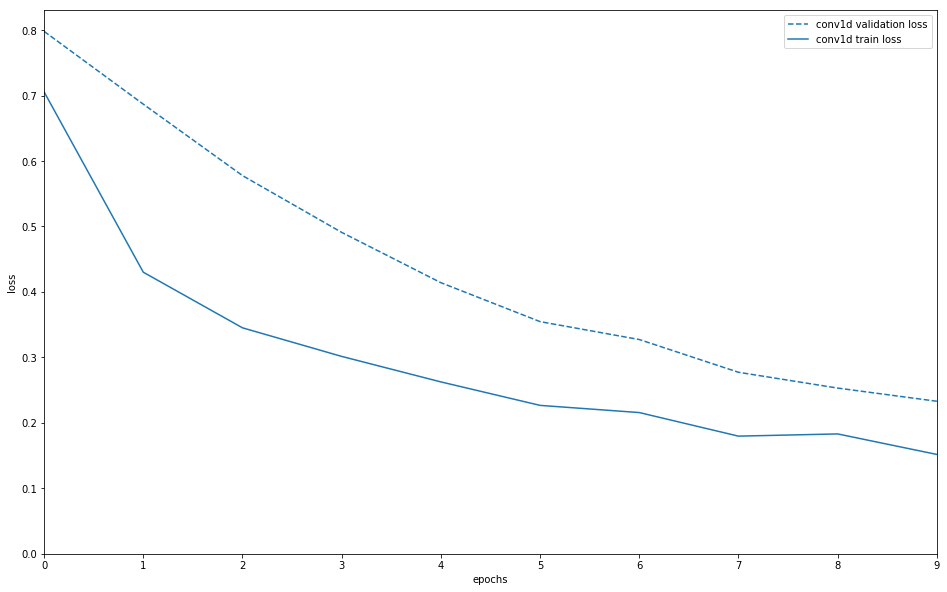

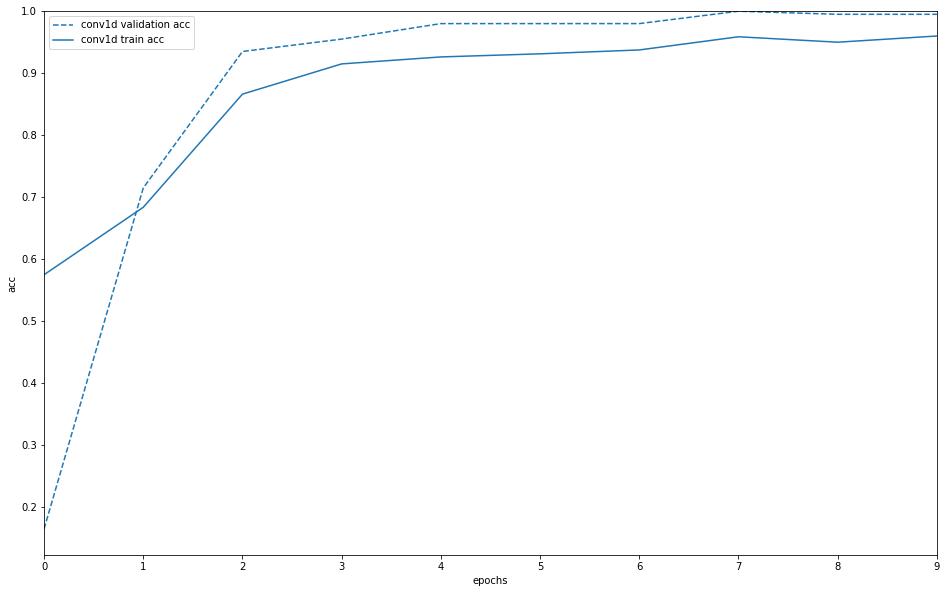

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_history(histories, key='loss', ymin=None, ymax=None):
    plt.figure(figsize=(16,10))    
    for name, history in histories:
        validation_plot = plt.plot(history.epoch, 
                                   history.history['val_' + key], 
                                   '--', 
                                   label=name + ' validation ' + key)
        plt.plot(history.epoch, 
                 history.history[key], 
                 color=validation_plot[0].get_color(),
                 label=name + ' train ' + key)
        plt.xlabel('epochs')
        plt.ylabel(key.replace('_',' '))
        plt.legend()
        plt.xlim([0, max(history.epoch)])
        if ymin is not None:
            plt.ylim(bottom=ymin)
        if ymax is not None:
            plt.ylim(top=ymax)
    
plot_history([('conv1d', history)], ymin=0)
plot_history([('conv1d', history)], key='acc', ymax=1)


## Various ways to visualize the model architecture

In [120]:
print('model.inputs', model.inputs)
print('model.outputs', model.outputs)
model.summary()

from contextlib import redirect_stdout
with open('model.summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

model.inputs [<tf.Tensor 'conv1d_1_input:0' shape=(?, 40, 4) dtype=float32>]
model.outputs [<tf.Tensor 'dense_1/Sigmoid:0' shape=(?, 1) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 23, 1)             73        
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 1)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 24        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


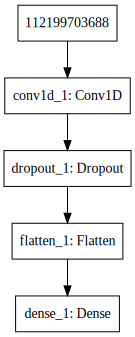

In [145]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [27]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

Convolution parameter shape: (19, 4)


In [28]:
num2seq = ['A','C','G','T']

''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])

'AAAGAAGGAAGGGAAGGAA'